# Assignment

## Import Libraries

In [29]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

## Read and Analyze Data


In [30]:
# Read input file
input_df = gpd.read_file("resa_girasole_2022.gpkg")

In [31]:
# Show input dataset
input_df

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (1333142.685 5597543.903)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (1333141.706 5597572.841)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (1333141.672 5597604.934)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (1333142.284 5597633.165)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (1333142.195 5597662.213)
...,...,...,...,...,...,...,...,...
1957,"3 set 2022, 20:13:03","11,9757431","44,8480422",2260.0,4.77,139.125,30.8,POINT (1333133.624 5597630.48)
1958,"3 set 2022, 20:13:19","11,9757395","44,8482399",2460.0,4.78,139.417,24.6,POINT (1333133.223 5597661.522)
1959,"3 set 2022, 20:13:34","11,9757408","44,8484282",2330.0,4.78,139.417,24.6,POINT (1333133.368 5597691.088)
1960,"3 set 2022, 20:13:49","11,9757414","44,848618",1950.0,4.99,145.542,24.6,POINT (1333133.435 5597720.889)


Since the names of the columns are not uniformed there are some preliminary steps to do:
- lower every column name;
- fix the "longitudin" column by adding the "e" letter at the end and make it "longitudine".

In [32]:
# Uniforming column names
input_df.columns = [i.lower() for i in input_df.columns]

# Rename column name in order to add missing character
input_df = input_df.rename(columns={"longitudin":"longitudine"})

print(input_df.columns)


Index(['data/ora', 'longitudine', 'latitudine', 'resakg', 'velocita', 'area',
       'umidita', 'geometry'],
      dtype='object')


Now it's time to do a prelimnary column analysis, in order to show some useful information about our data.
For every column are shown:
- column name;
- column type;
- count of missing values.


In [33]:
# Preliminary columns analysis
columns = input_df.columns

print("Preliminary columns analysis"+"\n")

for c in columns:
    print(f"Column: {c}")
    print(f"Column type: {input_df[c].dtype}")
    print(f"Null values: {input_df[c].isna().sum()}")
    

Preliminary columns analysis

Column: data/ora
Column type: object
Null values: 0
Column: longitudine
Column type: object
Null values: 0
Column: latitudine
Column type: object
Null values: 0
Column: resakg
Column type: float64
Null values: 0
Column: velocita
Column type: float64
Null values: 0
Column: area
Column type: float64
Null values: 0
Column: umidita
Column type: float64
Null values: 37
Column: geometry
Column type: geometry
Null values: 0


Since there are some missing values, the records that cointain them are removed from the dataset.

In [34]:
# Removing noise from data: discard records with null values
input_df = input_df.dropna(how="any", axis=0).reset_index(drop=True)

In order to facilitate future operations, the values of the columns "latitudine" and "longitudine" are converted from string into float numbers.

In [35]:
# Convert latitude and longitude to numeric values

# Convert decimal separator from comma to point
input_df["latitudine"] = input_df["latitudine"].str.replace(",",".")
input_df["longitudine"] = input_df["longitudine"].str.replace(",",".")

# Convert columns data types
input_df["latitudine"] = input_df["latitudine"].astype(float)
input_df["longitudine"] = input_df["longitudine"].astype(float)

Now it's time for feature engineering.<br>
The values of the column "resakg" represent the quantity harvested between different observation, while the values of the column "area" represent the area between different observation.<br>
In order to get a better understanding of how the harvest went in the different places of our observation area, a new feature called "resa_unitaria" it's created by dividing the "resakg" values by the ones from "area".<br>
With this new feature we have the quantity of harvest per square meter and we can find the places with more and less harvest. 


In [36]:
# Create new feature: starting from resakg and area we compute the resakg/area in order to uniform the measurements
input_df["resa_unitaria"] = input_df["resakg"] / input_df["area"]

Let's have a look at the new feature:
- max value;
- min value;
- mean value;
- median value.

In [37]:
# Analyze the new feature: find max, min, mean, median
print("Statistics of the new feature 'resa_unitaria': ")
print(f"Max value: {input_df['resa_unitaria'].max()}")
print(f"Min value: {input_df['resa_unitaria'].min()}")
print(f"Mean value: {input_df['resa_unitaria'].mean()}")
print(f"Median value: {input_df['resa_unitaria'].median()}")

Statistics of the new feature 'resa_unitaria': 
Max value: 133.33333333333334
Min value: 0.2506265664160401
Mean value: 16.32393786825599
Median value: 16.251465717635927


And now, using the columns "latitudine" and "longitudine" as a spatial reference, the values of the new feature are plotted to see their spatial distribution and shape.
In this notebook all the spatial references will be taken from these two features, instead of "geometry", because of their simplicity.

Text(0.5, 1.0, 'Resa Unitaria - Original Dataset')

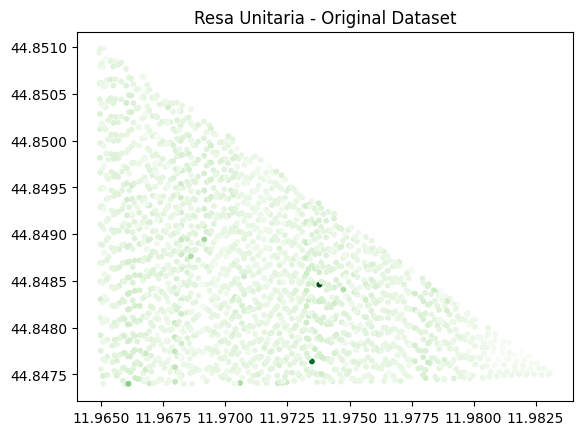

In [38]:
# Visualize the data about the new feature "resa_unitaria"
plt.scatter(input_df["longitudine"],input_df["latitudine"],c=input_df["resa_unitaria"], s=10, cmap="Greens")
plt.title("Resa Unitaria - Original Dataset")

## Spatial Interpolation

### Definition of the interpolation area

In order to performe a good spatial interpolation, the first step required is the definition of the boudaries of the analysis area. <br>
Let's find the minimum and maximum values of our "latitudine" and "longitudine" features.

In [39]:
# Compute the boundaries of our data
lat_min = input_df["latitudine"].min()
lat_max = input_df["latitudine"].max()

long_min = input_df["longitudine"].min()
long_max = input_df["longitudine"].max()

print(f"Lat: min {lat_min}, max {lat_max}")
print(f"Long: min {long_min}, max {long_max}")

Lat: min 44.8473917, max 44.8509863
Long: min 11.9649185, max 11.9830934


In the next few cells, using the boundaries just computed, it's generated a grid of equally spaced points that replicates the shape of the analysis area. <br>


In [40]:
# Define the grid of points to spatially interpolate

# Create a squared grid of points
nx, ny = 100, 100
x = np.linspace(long_min - 0.001, long_max + 0.001, nx)
y = np.linspace(lat_max + 0.001, lat_min - 0.001, ny)
xv, yv = np.meshgrid(x, y)

# Transform all the points outside of the area of interest into zeros
xv = np.tril(xv, k=0)
yv = np.tril(yv, k=0)

# Flatten the 2D arrays
xv = xv.flatten()
yv = yv.flatten()

In [41]:
# Create a new dataframe with the grid of points just created
grid_df = pd.DataFrame()
grid_df["latitudine"] = yv
grid_df["longitudine"] = xv

In [42]:
# Remove all the points that aren't included in the area of interpolation
grid_df = grid_df[(grid_df["latitudine"] > 0) & (grid_df["longitudine"] > 0)].reset_index(drop = True)
grid_df

,latitudine,longitudine
0,44.851986,11.963919
1,44.851930,11.963919
2,44.851930,11.964122
3,44.851873,11.963919
4,44.851873,11.964122
...,...,...
5045,44.846392,11.983278
5046,44.846392,11.983482
5047,44.846392,11.983686
5048,44.846392,11.983890


### Interpolation Algorithm: inverse distance weighting

Once the grid of points is created, it's time to apply the spatial interpolation algorithm: in this notebook it's used the Inverse Distance Weighting.<br>
For every point of the grid:
- compute the distance from every point of our input dataset;
- sort the distances and find the 5 nearest known points;
- if one of the distances is 0, then assign to the grid point the "resa_unitaria" value of the input point with distance = 0;
- if not:
    - assign a weight to every one of the 5 nearest points (the nearest of them gets the bigger weight)
    - compute the "resa_unitaria" value of the grid point as the weighted average of the 5 values.

In [43]:
# Define the function to compute the distance between two points
def euclidean_distance(lat_a, lat_b, long_a, long_b):
    return np.sqrt((lat_a-lat_b)**2 + (long_a-long_b)**2)

In [44]:
# Define the array of values to compute
resa_unitaria_IDW=[]

# Iterate through every point to interpolate
for i in range (len(grid_df)):
    
    # Determine the number of nearest points that will determine the value of the point to analyze
    number_nearest_points = 5
    distance_list = []

    # Compute distances of every known point
    for j in range (len(input_df)):
        distance_list.append(euclidean_distance(grid_df["latitudine"][i],
                                                input_df["latitudine"][j],
                                                grid_df["longitudine"][i],
                                                input_df["longitudine"][j]))
        
    # Find the nearest points
    distance_list = pd.Series(distance_list)
    distance_list = distance_list.sort_values(ascending=True)
    distance_list = distance_list[0:number_nearest_points]

    # Case if the point to interpolate is already known
    if distance_list.iloc[0] == 0:
        resa_unitaria_IDW.append(input_df["resa_unitaria"][distance_list.index.values[0]])

    # Case if the point to interpolate is not known
    else:
        resa_nearest_points = input_df["resa_unitaria"][distance_list.index.values]

        weights_nearest_points= 1/distance_list**2

        resa_unitaria_IDW.append(np.dot(np.transpose(resa_nearest_points),weights_nearest_points)/np.sum(weights_nearest_points))


resa_unitaria_IDW = np.array(resa_unitaria_IDW)

In [45]:
# Store results in the dataset as a new feature

grid_df["resa_unitaria_IDW"] = resa_unitaria_IDW

Text(0.5, 1.0, 'Resa unitaria - Grid Spatial Interpolation')

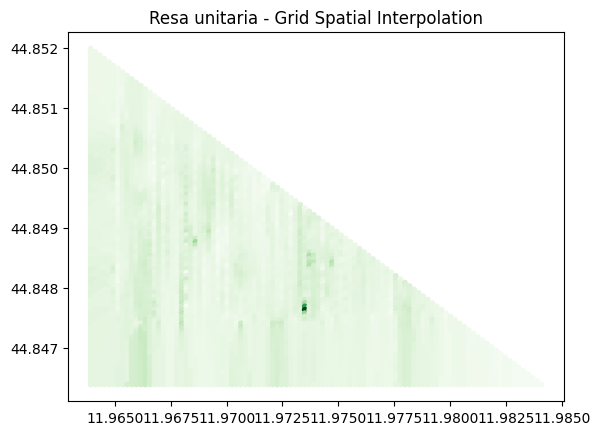

In [46]:
plt.scatter(grid_df["longitudine"],grid_df["latitudine"],c=grid_df["resa_unitaria_IDW"],s=10, cmap="Greens")
plt.title("Resa unitaria - Grid Spatial Interpolation")

## Correlate results with vegetational vigor index


Now that the Spatial Interpolation for the "resa_unitaria" feature, it's time to correlate the results with a vegetational vigor index.
For computing that index, the features "velocita" and "umidita" are used:
- "velocita" represents the speed of the harvester
- "umidita" represents the humidity of the product harvested. <br> <br>


Text(0.5, 1.0, 'Velocità - Original Dataset')

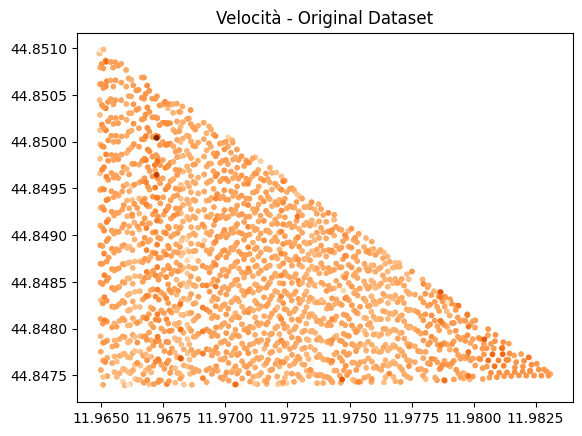

In [47]:
# Visualize the data about the feature "velocita"
plt.scatter(input_df["longitudine"],input_df["latitudine"],c=input_df["velocita"], s=10, cmap="Oranges")
plt.title("Velocità - Original Dataset")

Text(0.5, 1.0, 'Umidità - Original Dataset')

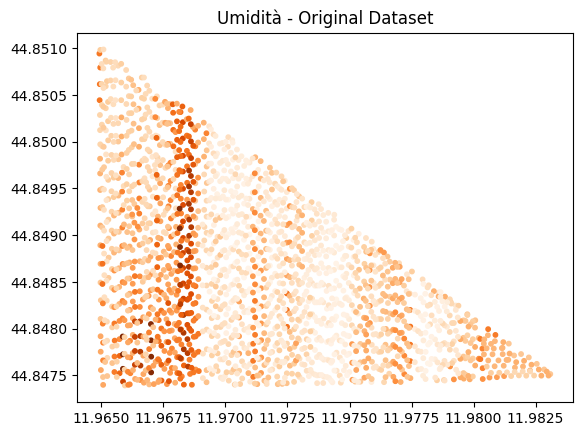

In [48]:
# Visualize the data about the feature "umidita"
plt.scatter(input_df["longitudine"],input_df["latitudine"],c=input_df["umidita"], s=10, cmap="Oranges")
plt.title("Umidità - Original Dataset")

The first operation its to calculate the "velocita_unitaria" feature by dividing the "velocita" feature by the "area". 

In [49]:
# Create the vegetational vigor index

# First step: create a new feature in order to find the velocity per mq
input_df["velocita_unitaria"] = input_df["area"] / input_df["velocita"]

Theoretically, more humid is the product, more difficult is for the harvester to collect it: thus, the value of "velocita_unitaria" it's increased by the percentage that it's indicated in the "umidita" feature. <br>
With this operation, the humidity difference are flatten in order to indicate a teorical dry speed if all the product were dry. <br>
That's why the new feature is called "velocita_secco": higher values represents a lower vigor product that it's harvested more easily, while lower values of this new feature represents a stronger vegetation.

In [50]:
# Second step: increase the "velocità_unitaria" feature by the percentage indicated in the "umidita" feature, because theoretically a plant that is more humid is more difficult to harvest
input_df["velocita_unitaria_secco"] = input_df["velocita_unitaria"] * (1+input_df["umidita"]/100)

Text(0.5, 1.0, 'Velocità unitaria a secco - Original Dataset')

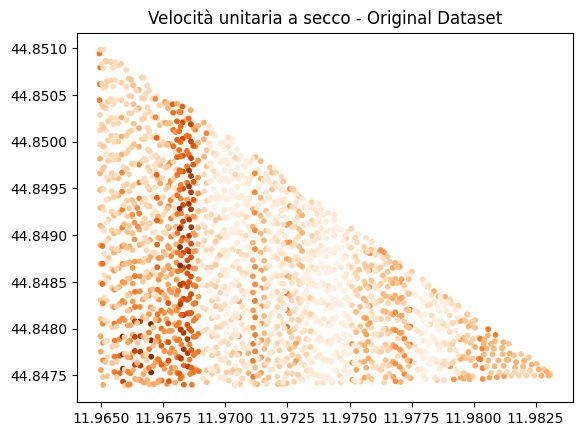

In [51]:
# Visualize the new feature's values
plt.scatter(input_df["longitudine"],input_df["latitudine"],c=input_df["velocita_unitaria_secco"], s=10, cmap="Oranges")
plt.title("Velocità unitaria a secco - Original Dataset")

Now that the new feature is created, it's necessary to spatial interpolate it in order to correlate the results of the "resa unitaria" feature with the vegetational vigor index that is derived from this feature.

In [53]:
# Spatial interpolation of the new feature to find the values of every point in our grid

# Define the array of values to compute
velocita_unitaria_secco_IDW=[]

# Iterate through every point to interpolate
for i in range (len(grid_df)):
    
    # Determine the number of nearest points that will determine the value of the point to analyze
    number_nearest_points = 5
    distance_list = []

    # Compute distances of every known point
    for j in range (len(input_df)):
        distance_list.append(euclidean_distance(grid_df["latitudine"][i],
                                                input_df["latitudine"][j],
                                                grid_df["longitudine"][i],
                                                input_df["longitudine"][j]))
        
    # Find the nearest points
    distance_list = pd.Series(distance_list)
    distance_list = distance_list.sort_values(ascending=True)
    distance_list = distance_list[0:number_nearest_points]

    # Case if the point to interpolate is already known
    if distance_list.iloc[0] == 0:
        velocita_unitaria_secco_IDW.append(input_df["velocita_unitaria_secco"][distance_list.index.values[0]])

    # Case if the point to interpolate is not known
    else:
        vus_nearest_points = input_df["velocita_unitaria_secco"][distance_list.index.values]

        weights_nearest_points= 1/distance_list**2

        velocita_unitaria_secco_IDW.append(np.dot(np.transpose(vus_nearest_points),weights_nearest_points)/np.sum(weights_nearest_points))


velocita_unitaria_secco_IDW = np.array(velocita_unitaria_secco_IDW)

In [54]:
# Store results in the dataset as a new feature
grid_df["velocita_unitaria_secco_IDW"] = velocita_unitaria_secco_IDW

Text(0.5, 1.0, 'Velocità unitaria a secco - Grid Spatial Interpolation')

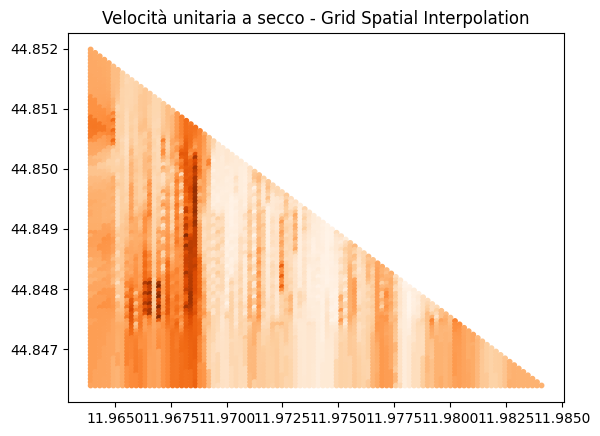

In [61]:
# Visualize the results of the interpolation
plt.scatter(grid_df["longitudine"],grid_df["latitudine"],c=grid_df["velocita_unitaria_secco_IDW"],s=10, cmap="Oranges")
plt.title("Velocità unitaria a secco - Grid Spatial Interpolation")

Once this spatial interpolation is completed, it's time to correlate our results in order to see if the places with the best harvest are also the ones with the lower velocity and thus with the better vegetation vigor.

In [56]:
# Correlate the features

grid_df["resa_unitaria_IDW"].corr(grid_df["velocita_unitaria_secco_IDW"])

np.float64(0.005650748663538797)

This result, very close to 0, indicates that there isn't a strong linear correlation between the two features. Let's double check with a scatter plot.

Text(0.5, 1.0, 'Correlation between Spatial Interpolation and Vegetational Vigor Index')

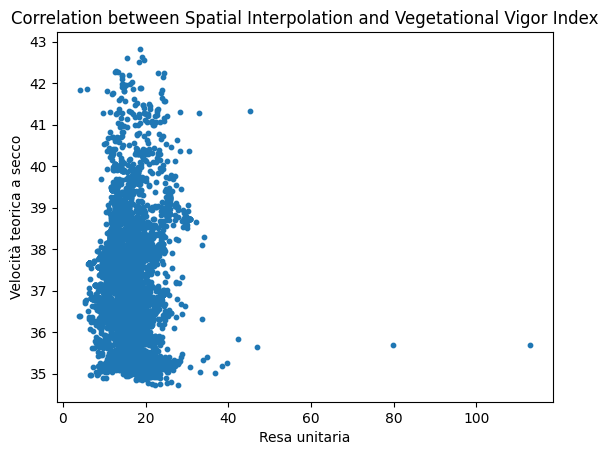

In [60]:
plt.scatter(grid_df["resa_unitaria_IDW"],grid_df["velocita_unitaria_secco_IDW"], s=10)
plt.xlabel("Resa unitaria")
plt.ylabel("Velocità teorica a secco")
plt.title("Correlation between Spatial Interpolation and Vegetational Vigor Index")